# DTSA5511 Week 3 Assignment

**Problem Description**

For this assignment, the challenge is a binary image classification problem where we will identify metastatic cancer in small image patches taken from larger digital pathology scans.

We would need to use the center 32x32 pixels to identify a positive sample.

I will start by importing the necessary libraries.


In [2]:
!pip install tensorflow
import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 623.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00


In [3]:
print(tf.__version__)

2.19.0


In [5]:
from tensorflow import keras
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
!pip install opencv-python
import cv2
import io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.9 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Exploratory Data Analysis**

We have been given a training dataset with training images and the file name "train_labels.csv" for the training labels. I have uploaded in my Google Drive, as I'm using the Google Colab.

We will first analyse the training data set.

In [7]:
train_labels = pd.read_csv('/content/drive/MyDrive/DTSA5511/train_labels.csv')
train_labels.shape

(220025, 2)

In [8]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


There are 220,025 training examples, with the ID of the image and the corresponding label '0' or '1' for no cancer or cancer.

In [9]:
trainlabel_counts = train_labels['label'].value_counts()
trainlabel_counts

,count
label,
0,130908
1,89117


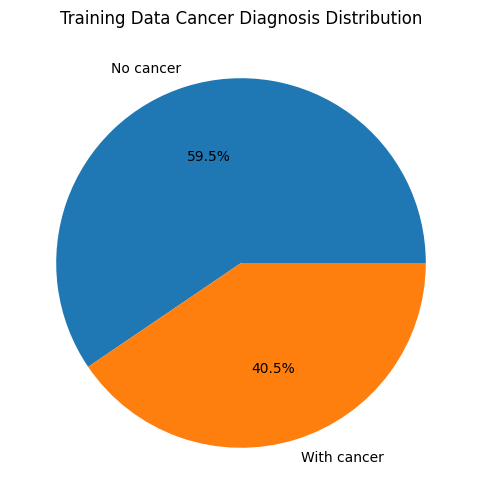

In [10]:
counts = [130908, 89117]
labels = ["No cancer", "With cancer"]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("Training Data Cancer Diagnosis Distribution")
plt.show()

We can see from the plot above that the training data has a higher distribution of "no cancer" images, but I think the data distribution is balanced enough that the positive cases can be identified.

Now we will just take a look at how a sample image looks like and the shape of the image:

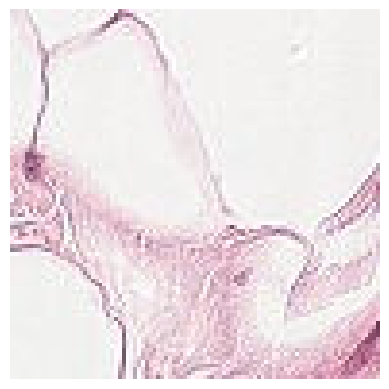

In [19]:
img_path = '/content/drive/MyDrive/DTSA5511/0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif'
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
print("Image size (width, height):", img.size)

img_array = np.array(img)
print(f"Image shape: {img_array.shape}")

Image size (width, height): (96, 96)
Image shape: (96, 96, 3)


**Data Preprocessing**

The data size is large, with more than 200,000 images. For more efficient training, I have converted the data to TFRecords format separately, which I will import in.


In [20]:
tfrecord_file = "/content/drive/MyDrive/DTSA5511/histopathologic_dataset.tfrecord"
raw_data = tf.data.TFRecordDataset(tfrecord_file)

#What is stored in the tfrecord:
features = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

I then need to decode the tif images and parse the labels manually. I will write a function to do that. Because the images are in ".tif" format, I have to use the image bytes to read in the image.

In [21]:
def decode_function(p):

    decode_features = tf.io.parse_single_example(p, features)

    img_bytes = decode_features['image'].numpy()

    img_array = np.frombuffer(img_bytes, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

    if img is None:
        img = Image.open(io.BytesIO(img_bytes))
        img = np.array(img)

    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = img / 255.0
    label = tf.convert_to_tensor(decode_features['label'], dtype=tf.int64)
    img = tf.reshape(img, [96, 96, 3])

    return img, label

I have used a larger batch size for faster training. However, for more optimal results, I would think a lower batch size would work better.

In [22]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(1108)

decoded_data = raw_data.map(lambda x: tf.py_function(decode_function, [x], [tf.float32, tf.int64]))

def set_shapes(img, label):
    img.set_shape([96, 96, 3])
    label.set_shape([])
    return img, label

decoded_data = decoded_data.map(set_shapes)

decoded_data = decoded_data.shuffle(1000, seed=1108).batch(BATCH_SIZE).prefetch(AUTOTUNE)

I then split my dataset into a training dataset and a validation dataset, to feed into my model. My training dataset will be 80%, with validation size of remaining 20%.

In [23]:
dataset_size = sum(1 for _ in decoded_data)
print(dataset_size)

train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset = decoded_data.take(train_size)
val_dataset = decoded_data.skip(train_size)

1719


Here I am building my model. I use the Cropping 2D layer to crop my image to focus on the 32x32 center pixel. And I have added my convolutional layers.

For the optimizer, I am using 'Adam' and a learning rate of 0.0001 for a start, since my dataset is quite large.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Cropping2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Cropping2D(cropping=32, input_shape=(96, 96, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cropping2d (Cropping2D)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,685 (3.60 MB)

 Trainable params: 314,561 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 629,124 (2.40 MB)

In [25]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "CNN.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)


Epoch 1/10
   1375/Unknown 274s 196ms/step - accuracy: 0.7187 - loss: 0.5525

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 592s 428ms/step - accuracy: 0.7187 - loss: 0.5525 - val_accuracy: 0.7703 - val_loss: 0.4928
Epoch 2/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 590s 428ms/step - accuracy: 0.7686 - loss: 0.4959 - val_accuracy: 0.7771 - val_loss: 0.4799
Epoch 3/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 589s 427ms/step - accuracy: 0.7765 - loss: 0.4820 - val_accuracy: 0.7851 - val_loss: 0.4693
Epoch 4/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 589s 427ms/step - accuracy: 0.7821 - loss: 0.4722 - val_accuracy: 0.7927 - val_loss: 0.4563
Epoch 5/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 588s 426ms/step - accuracy: 0.7912 - loss: 0.4599 - val_accuracy: 0.7993 - val_loss: 0.4494
Epoch 6/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 584s 423ms/step - accuracy: 0.7983 - loss: 0.4481 - val_accuracy: 0.7950 - val_loss: 0.4544
Epoch 7/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 590s 428ms/step - accuracy: 0.8005 - loss: 0.4437 - val_accuracy: 0.8101 - val_loss: 0.4303
Epoch 8/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 585s 424ms/step - accuracy: 0.8

My model accuracy from the model seems to be decent, with an accuracy of 0.8108 after the last epoch. Let's try to adjust the hyperparameters like the learning rate. I'm trying to find an optimal learning rate. 0.0001 could be too slow. I will try 0.001 instead.

In [26]:
model2 = Sequential([
    Cropping2D(cropping=32, input_shape=(96, 96, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/cropping2d.py:57: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cropping2d_1 (Cropping2D)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,685 (3.60 MB)

 Trainable params: 314,561 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 629,124 (2.40 MB)

In [27]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "CNN2.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

cnn2_history = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)


Epoch 1/10
   1375/Unknown 275s 197ms/step - accuracy: 0.7415 - loss: 0.5269

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 591s 427ms/step - accuracy: 0.7416 - loss: 0.5269 - val_accuracy: 0.7749 - val_loss: 0.4957
Epoch 2/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 585s 424ms/step - accuracy: 0.7848 - loss: 0.4724 - val_accuracy: 0.7696 - val_loss: 0.4965
Epoch 3/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 596s 432ms/step - accuracy: 0.7969 - loss: 0.4513 - val_accuracy: 0.8038 - val_loss: 0.4372
Epoch 4/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 588s 426ms/step - accuracy: 0.8036 - loss: 0.4377 - val_accuracy: 0.8126 - val_loss: 0.4251
Epoch 5/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 586s 425ms/step - accuracy: 0.8073 - loss: 0.4301 - val_accuracy: 0.8065 - val_loss: 0.4320
Epoch 6/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 587s 426ms/step - accuracy: 0.8105 - loss: 0.4253 - val_accuracy: 0.8133 - val_loss: 0.4176
Epoch 7/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 589s 427ms/step - accuracy: 0.8137 - loss: 0.4193 - val_accuracy: 0.8193 - val_loss: 0.4074
Epoch 8/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 589s 427ms/step - accuracy: 0.8

The accuracy does improve slightly to 0.8196, though it is not too different from my initial model. Perhaps we might get a higher accuracy if I build upon a pre-trained model. I chose to use the VGG16 model as my base model. I will use the learning rate of 0.001 in my optimizer, given that this learning rate produced better results in my self-developed CNN model. Let's see if the VGG16 model base would provide better results.

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

vggbase = VGG16(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

vggbase.trainable = False

vggmodel = Sequential([
    vggbase,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

vggmodel.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
vggmodel.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "vgg.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

vgghistory = vggmodel.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)


Epoch 1/10
   1375/Unknown 726s 525ms/step - accuracy: 0.7820 - loss: 0.4653

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 1154s 837ms/step - accuracy: 0.7820 - loss: 0.4653 - val_accuracy: 0.8346 - val_loss: 0.3746
Epoch 2/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 1160s 842ms/step - accuracy: 0.8151 - loss: 0.4100 - val_accuracy: 0.8395 - val_loss: 0.3624
Epoch 3/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 1166s 847ms/step - accuracy: 0.8222 - loss: 0.3953 - val_accuracy: 0.8494 - val_loss: 0.3521
Epoch 4/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 1169s 848ms/step - accuracy: 0.8265 - loss: 0.3862 - val_accuracy: 0.8515 - val_loss: 0.3456
Epoch 5/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 1162s 844ms/step - accuracy: 0.8293 - loss: 0.3833 - val_accuracy: 0.8581 - val_loss: 0.3404
Epoch 6/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 1160s 842ms/step - accuracy: 0.8316 - loss: 0.3779 - val_accuracy: 0.8554 - val_loss: 0.3365
Epoch 7/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 1167s 848ms/step - accuracy: 0.8344 - loss: 0.3738 - val_accuracy: 0.8578 - val_loss: 0.3380
Epoch 8/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 1162s 844ms/step - accur

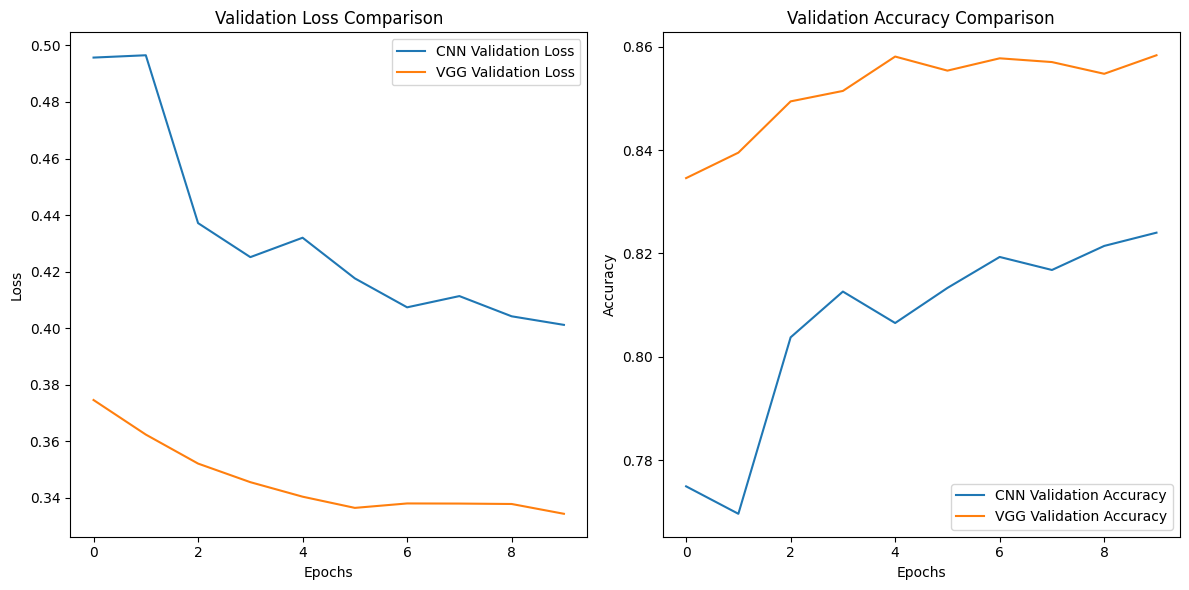

In [68]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cnn2_history.history['val_loss'], label='CNN Validation Loss')
plt.plot(vgghistory.history['val_loss'], label='VGG Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn2_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(vgghistory.history['val_accuracy'], label='VGG Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The VGG model produces better results, with high validation accuracy and lower validation loss. This could be because the base model is already trained on Imagenet with more parameters and is already a very refined model which I could tap on to build upon this model for our use case.

**Using the model on my test dataset**

Now that I have my VGG model, I will use it to predict the labels of my test dataset.

In [34]:
from tensorflow.keras.models import load_model

modeltouse = load_model('vgg.keras')

Similar to my training dataset, I separately converted the test folder into a TFRecord format, for more efficient processing, as the dataset is still quite large, with more than 50,000 images. Hence, I also had to write another function to decode the images. There are slight modifications, as this dataset does not have labels, unlike the training data.

In [35]:
tfrecord_test = "/content/drive/MyDrive/DTSA5511/histopathologic_dataset_test.tfrecord"
rawtestdata = tf.data.TFRecordDataset(tfrecord_test)

In [50]:
def decode_testfunction(p):
    features = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'filename': tf.io.FixedLenFeature([], tf.string),}

    decode_features = tf.io.parse_single_example(p, features)

    img_bytes = decode_features['image'].numpy()

    img_array = np.frombuffer(img_bytes, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

    if img is None:
        img = Image.open(io.BytesIO(img_bytes))
        img = np.array(img)

    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = img / 255.0

    img = tf.reshape(img, [96, 96, 3])
    filename = decode_features['filename'].numpy().decode('utf-8')

    return img, filename

In [58]:
decodedtestdata = rawtestdata.map(lambda x: tf.py_function(decode_testfunction, [x], [tf.float32, tf.string]))

decodedtestdata = decodedtestdata.batch(BATCH_SIZE)

In [59]:
files = []
predictions = []

for batchimg, batchfilename in decodedtestdata:
  preds = modeltouse.predict(batchimg)
  predictedlabel = (preds > 0.5).astype(int)
  batchfilename = [fname.numpy().decode('utf-8') for fname in batchfilename]
  files.extend(batchfilename)
  predictions.extend(predictedlabel.flatten())

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

In [60]:
df_pred = pd.DataFrame({
    'id': files,
    'label': predictions
})

In [61]:
df_pred.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif,1
2,19709bec800f372d0b1d085da6933dd3ef108846.tif,0
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif,0


In [65]:
df_pred['id'] = df_pred['id'].str.replace('.tif', '', regex=False)

In [66]:
df_pred.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,1
2,19709bec800f372d0b1d085da6933dd3ef108846,0
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0


In [67]:
df_pred.to_csv('week3.csv', index=False)

**Conclusion**

Overall, after many experiments with the CNN model, I found that it was important to have an optimal learning rate. Initially I thought a lower learning rate would be better for a huge dataset, but it took too long, and the accuracy also turned out to be lower than if I had used a higher learning rate.

Transfer learning with pre-trained models like the VGG16 that I used also helped with performance of the model, probably because it had already been trained on a even larger dataset and fine-tuned already. Given more time, I thought it would be interesting to try other pre-trained models like ResNet or MobileNet. I'm not sure if the performance would be comparable, with these other complex models. One challenge though would be that the images would need to be reshaped to fit into ResNet, which could add complexity to the task.